# import packages

In [1]:
# data preprocess
import pandas as pd 
import numpy as np 
import os 
from itertools import chain, repeat

# data EDA 
import matplotlib.pyplot as plt
import seaborn as sns

# Data Load

In [5]:
tr_base_path = './data/train'
te_base_path = './data/test'
submission_path = './submission'
infer_path = './inferencedata'
train_path = './trainingdata'

In [8]:
# file path = data directory
file_path = '../태양광예측/'

# train, submission data load 
train = pd.read_csv(tr_base_path +'/train.csv')
submission = pd.read_csv('./data/sample_submission.csv')

# test load 
t_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    t_test.append(temp)
    
test = pd.concat(t_test)

In [ ]:
print('train shape :', train.shape)
print('test shape :', test.shape)
print('submission shape :', submission.shape)

In [ ]:
print('train_na_values :', train.isnull().sum().sum())
print('test_na_values :', test.isnull().sum().sum())

# Data PreProcess

## Basic p-pro

In [9]:
def base_preprocess(data) : 
    
    # 원래 방법대로 한다면, 마지막 48개행은 target2에 대해 미지의 값을 가진게 아닌가?
    # step1 : 하루 뒤, 이틀 뒤 target 값 가져오기 
    data['1day_after_target'] = data.shift(-48)['TARGET']
    data['2day_after_target'] = data.shift(-96)['TARGET']
    
    # step2 : 7일간의 segment를 할당하여 예측을 진행 
    
    data = data.dropna(axis=0)
    
    return(data)

In [10]:
df_train = base_preprocess(train)
df_test = test.copy()

In [452]:
print('train shape :' ,train.shape)
print('df_train shape :', df_train.shape)
print('train - df_train shape :', train.shape[0]-df_train.shape[0])

train shape : (52560, 11)
df_train shape : (52464, 11)
train - df_train shape : 96


## Feature engineering

### 현재 - 직전 이틀간의 평균

#### train data

In [12]:
def train_2day_variable(df_train, rolling_num) : 
    
    hour_lists = []

    numbers = list(np.arange(0,24,1))
    n_list = [2]*24

    hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

    for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 

        hour_lists.append(df_train[(df_train['Hour']==hours) & (df_train['Minute']==minutes)])

    for num in range(len(hour_lists)) : 

        hour_lists[num]['2days_mean_DHI'] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
        hour_lists[num]['2days_mean_DNI'] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
        hour_lists[num]['2days_mean_T'] = hour_lists[num]['T'].rolling(rolling_num).mean()

        hour_lists[num]['2days_mean_DHI'] = hour_lists[num]['DHI']-hour_lists[num]['2days_mean_DHI']
        hour_lists[num]['2days_mean_DNI'] = hour_lists[num]['DNI']-hour_lists[num]['2days_mean_DNI']
        hour_lists[num]['2days_mean_T'] = hour_lists[num]['T']-hour_lists[num]['2days_mean_T']
        
    df_train = pd.concat(hour_lists).sort_index() 
    
    return(df_train)

In [13]:
df_train = train_2day_variable(df_train, rolling_num=3)

/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sinmin-yong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

#### test data

In [455]:
def test_2day_variable(df_test, rolling_num) : 
    
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    df_test['label'] = label_list 

    test_dataset = []

    for label_num in df_test.label.unique() : 

        hour_lists = []
        numbers = list(np.arange(0,24,1))
        n_list = [2]*24
        df_test2 = df_test[df_test['label']==label_num]

        hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

        for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
            hour_lists.append(df_test2[(df_test2['Hour']==hours) & (df_test2['Minute']==minutes)])

        for num in range(len(hour_lists)) : 
            hour_lists[num]['2days_mean_DHI'] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_DNI'] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_T'] = hour_lists[num]['T'].rolling(rolling_num).mean()

            hour_lists[num]['2days_mean_DHI'] = hour_lists[num]['DHI']-hour_lists[num]['2days_mean_DHI']
            hour_lists[num]['2days_mean_DNI'] = hour_lists[num]['DNI']-hour_lists[num]['2days_mean_DNI']
            hour_lists[num]['2days_mean_T'] = hour_lists[num]['T']-hour_lists[num]['2days_mean_T']

        temp = pd.concat(hour_lists)
        test_dataset.append(temp)
        
    df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
    df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 
    
    return(df_test)

In [456]:
df_test = test_2day_variable(df_test, rolling_num=3)

<ipython-input-455-128e0fb6bb07>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_lists[num]['2days_mean_DHI'] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
<ipython-input-455-128e0fb6bb07>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_lists[num]['2days_mean_DNI'] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
<ipython-input-455-128e0fb6bb07>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

#### 변수 EDA

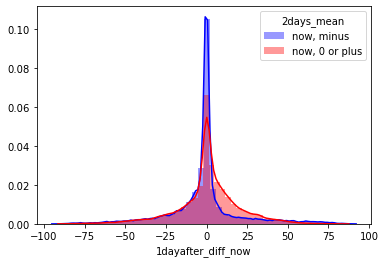

In [457]:
def twoday_eda(eda_data) : 
    
    eda_data = df_train.copy()
    eda_data['1dayafter_diff_now'] = eda_data['1day_after_target'] - eda_data['TARGET']

    sns.distplot(eda_data[eda_data['2days_mean_DHI']<0]['1dayafter_diff_now']
                 , color='blue', label='now, minus')
    sns.distplot(eda_data[eda_data['2days_mean_DHI']>0]['1dayafter_diff_now']
                 , color='red', label='now, 0 or plus')

    plt.legend(title='2days_mean') 
    plt.show()
    
twoday_eda(df_train)

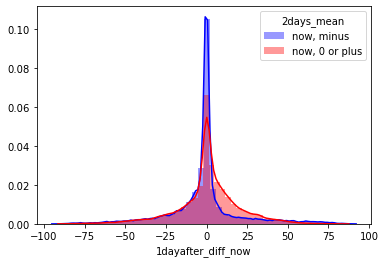

In [458]:
twoday_eda(df_train)

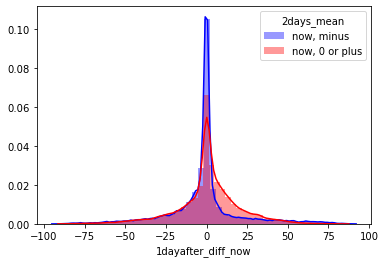

In [459]:
twoday_eda(df_train)

### K-means 결과 안좋음

In [460]:
from sklearn.cluster import KMeans

In [461]:
def kmeans_dataset_train(data) : 
    
    features = []
    
    f = data.groupby(['Day'])['DHI','DNI','WS','RH','T','TARGET'].mean()
    f.columns = f.columns+'_mean'
    features.append(f.reset_index())
    
    f = data.groupby(['Day'])['DHI','DNI','WS','RH','T','TARGET'].std()
    f.columns = f.columns+'_std'
    features.append(f.reset_index())
    
    
    data['GHI_less'] = data['DHI'] + data['DNI']
    def time_pil(data) : 

        texts = str(data['Hour']) + str(data['Minute'])[:1]

        return(texts)

    data['GHI_less'] = data['DHI'] + data['DNI']
    data['Time'] = data[['Hour','Minute']].apply(lambda x: time_pil(x), axis=1)
    data['GHI_less'] = data['GHI_less'].astype('int') 
    f = data[data['GHI_less']>0].groupby(['Day']).head(1)[['Day','Time','T','DHI','DNI','GHI_less']]
    f.columns = ['Day','First_time','First_T','First_DHI','First_DNI','GHI_less']
    features.append(f)
    
    
    dataset = pd.DataFrame({
        'Day' : np.arange(1,1093,1)
    })
    
    for datas in features : 
        dataset = pd.merge(dataset, datas, how='inner', on = 'Day')
    
    return(dataset)

In [462]:
tr_kmeans_data = kmeans_dataset_train(df_train)

<ipython-input-461-e2a0126e1158>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  f = data.groupby(['Day'])['DHI','DNI','WS','RH','T','TARGET'].mean()
<ipython-input-461-e2a0126e1158>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  f = data.groupby(['Day'])['DHI','DNI','WS','RH','T','TARGET'].std()


In [463]:
def kmeans_dataset_test(data) : 
    
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    data['label'] = label_list 
    
    features = []
    
    f = data.groupby(['label','Day'])['DHI','DNI','WS','RH','T','TARGET'].mean()
    f.columns = f.columns+'_mean'
    features.append(f.reset_index())
    
    f = data.groupby(['label','Day'])['DHI','DNI','WS','RH','T','TARGET'].std()
    f.columns = f.columns+'_std'
    features.append(f.reset_index())
    
    
    data['GHI_less'] = data['DHI'] + data['DNI']
    def time_pil(data) : 

        texts = str(data['Hour']) + str(data['Minute'])[:1]

        return(texts)

    data['GHI_less'] = data['DHI'] + data['DNI']
    data['Time'] = data[['Hour','Minute']].apply(lambda x: time_pil(x), axis=1)
    data['GHI_less'] = data['GHI_less'].astype('int') 
    f = data[data['GHI_less']>0].groupby(['label','Day']).head(1)[['label','Day','Time','T','DHI','DNI','GHI_less']]
    f.columns = ['label','Day','First_time','First_T','First_DHI','First_DNI','GHI_less']
    features.append(f)

    label_list = []

    for i in range(81) : 
        label_list.append([i]*6)

    label_list = [item for sublist in label_list for item in sublist]
    
    dataset = pd.DataFrame({
        'label' : label_list,
        'Day' : list(np.arange(1,7,1))*81
    })
    
    for datas in features : 
        dataset = pd.merge(dataset, datas, how='inner', on = ['label','Day'])
    
    return(dataset)

In [464]:
ts_kmeans_data = kmeans_dataset_test(df_test)

<ipython-input-463-05154eeae47b>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  f = data.groupby(['label','Day'])['DHI','DNI','WS','RH','T','TARGET'].mean()
<ipython-input-463-05154eeae47b>:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  f = data.groupby(['label','Day'])['DHI','DNI','WS','RH','T','TARGET'].std()


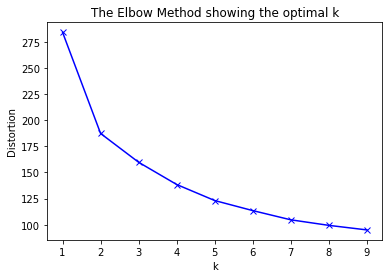

In [465]:
from scipy.spatial.distance import cdist
distortions = []

k_data = tr_kmeans_data.drop(['Day'],axis=1)

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(k_data)
    kmeanModel.fit(k_data)
    distortions.append(sum(np.min(cdist(k_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / k_data.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [466]:
num = 9

km = KMeans(n_clusters=num, random_state=2020)
km.fit(tr_kmeans_data.drop(['Day'],axis=1))

KMeans(n_clusters=9, random_state=2020)

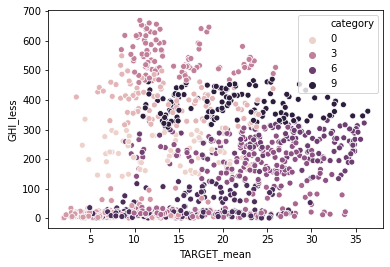

In [467]:
df = pd.DataFrame(tr_kmeans_data).copy()
df['category'] = km.labels_

sns.scatterplot(x='TARGET_mean',
               y='GHI_less',
               hue='category',
               data= df)

plt.show()

In [468]:
label_list = []

for i in range(81) : 
    label_list.append([i]*6)

label_list = [item for sublist in label_list for item in sublist]

kmeans_train = pd.DataFrame({
    'Day' : np.arange(1,1093,1),
    'category' : km.labels_
})

kmeans_test = pd.DataFrame({
    'label' : label_list,
    'Day' : list(np.arange(1,7,1))*81,
    'category' : km.predict(ts_kmeans_data.drop(['label','Day'],axis=1))
})

In [469]:
df_train = pd.merge(df_train, kmeans_train, how='inner', on=['Day'])
df_test = pd.merge(df_test, kmeans_test, how='inner', on=['label','Day'])

# 최종 데이터 점검

In [470]:
# df_train = df_train.drop(['GHI_less','Time'],axis=1)
# df_test = df_test.drop(['GHI_less','Time','label'],axis=1)

# df_train = df_train.dropna()
# df_test = df_test.dropna()
# df_test = df_test[df_test['Day']==6]

# df_train = df_train.drop(['Day'],axis=1)
# df_test = df_test.drop(['Day'],axis=1)

# df_train[['Hour','category']] = df_train[['Hour','category']].astype('category')
# df_test[['Hour','category']] = df_test[['Hour','category']].astype('category')

In [473]:
df_train = df_train.dropna()
df_train = df_train.drop(['Day','Minute'], axis=1)
df_train['Hour'] = df_train['Hour'].astype('category')

df_test = df_test.dropna()
df_test = df_test[df_test['Day']==6]
df_test = df_test.drop(['Day','Minute'], axis=1)
df_test['Hour'] = df_test['Hour'].astype('category')

df_test = df_test.drop(['label'],axis=1)

In [474]:
df_train = df_train.drop(['Minute'],axis=1)
df_test = df_test.drop(['Minute'],axis=1)

# Model

## train_test_split

In [475]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

drop_columns = ['1day_after_target','2day_after_target']
y1 = '1day_after_target'
y2 = '2day_after_target'

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.drop(drop_columns,axis=1), df_train[y1], test_size=0.33, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.drop(drop_columns,axis=1), df_train[y2], test_size=0.33, random_state=0)

In [476]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, df_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(df_test).round(2))
    return pred, model

# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, df_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, df_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [477]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds


C:\Users\Unknown\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\Unknown\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[500]	valid_0's quantile: 1.29928
[1000]	valid_0's quantile: 1.28807
[1500]	valid_0's quantile: 1.28462
[2000]	valid_0's quantile: 1.28574
Early stopping, best iteration is:
[1706]	valid_0's quantile: 1.28412
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.0229
[1000]	valid_0's quantile: 1.97842
[1500]	valid_0's quantile: 1.95956
[2000]	valid_0's quantile: 1.95201
[2500]	valid_0's quantile: 1.95043
[3000]	valid_0's quantile: 1.95132
Early stopping, best iteration is:
[2863]	valid_0's quantile: 1.94878
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.41776
[1000]	valid_0's quantile: 2.36401
[1500]	valid_0's quantile: 2.34394
[2000]	valid_0's quantile: 2.33408
[2500]	v

In [478]:
# Target2
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.37826
Early stopping, best iteration is:
[603]	valid_0's quantile: 1.37554
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.17216
[1000]	valid_0's quantile: 2.14037
[1500]	valid_0's quantile: 2.12181
[2000]	valid_0's quantile: 2.10787
[2500]	valid_0's quantile: 2.1017
[3000]	valid_0's quantile: 2.09379
[3500]	valid_0's quantile: 2.09104
Early stopping, best iteration is:
[3621]	valid_0's quantile: 2.09018
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.58427
[

In [479]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission.head(30)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [480]:
submission.to_csv('../태양광예측/pilryoung_20201228_2daysmeans_v5.csv', index=False)

## CV

In [64]:
def pinball(pred, actual):
    quantile_col = pred.columns.tolist()
    pred2 = pred.copy()
    actual2 = actual.copy()
    
    pred2.index = range(len(pred2))
    actual2.index = range(len(actual2))

    pinball_loss = []
    for item in quantile_col:
        pre_pinball = []
        for idx in range(len(pred2)):
            y = actual2.iloc[idx]
            z = pred2[item].iloc[idx]
            q = item
            
            if y >= z:
                value = (y - z)*q
                pre_pinball.append(value)
            else:
                value = (z - y)*(1 - q)
                pre_pinball.append(value)
        loss_mean = np.mean(pre_pinball)
        pinball_loss.append(loss_mean)
    
    fin = np.mean(pinball_loss)
    print(f'Pinball Loss: {fin}')
    
    return pinball_loss    

In [65]:
def LGBM_reg(X_train,y_train):
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # 랜덤모수 샘플 추론이 왜 안되지;;;
    # fold = StratifiedKFold(n_splits=5, shuffle = True)
    
    fold = KFold(n_splits=5, shuffle = True, random_state=2020)

    oof_preds = np.zeros([X_train.shape[0], len(quantiles)])

    feature_importance_df = pd.DataFrame(np.zeros([len(X_train.columns), len(quantiles)]))
    feature_importance_df.columns = quantiles
    
    fold_metric = []
    loss_ls = []
    # training
    target = y_train
    for fold_, (train_idx, valid_idx) in enumerate(
        fold.split(np.array(X_train), target)
    ):

        train_x, train_y = X_train.iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], target.iloc[valid_idx]

        oof_df = pd.DataFrame()
        for idx, q in enumerate(quantiles):
            print(f'\nquantile: {q}\n')
            model = LGBMRegressor(objective='quantile', 
                                  alpha=q,
                                  n_estimators=10000, 
                                  bagging_fraction=0.7, 
                                  learning_rate=0.027, 
                                  subsample=0.7
                                 )                   

            model.fit(train_x, 
                      train_y,
                      eval_metric = ['quantile'], 
                      eval_set=[(valid_x, valid_y)], 
                      early_stopping_rounds=300, 
                      verbose=1500
                     )

            oof_preds[[valid_idx],idx] = \
                model.predict(valid_x).round(2)

            oof_df[q] = model.predict(valid_x).round(2)
            # feature importance
            feature_importance_df[q] = model.feature_importances_ / 5
            
            
        metric = pinball(oof_df, valid_y)
        loss = np.mean(metric)
        print(f'\n FOLD {fold_}의 total pinball loss: {loss}\n')
        fold_metric.append(metric)
        loss_ls.append(loss)
        
        
        print('\n===================================================')
        print(f'FOLD {fold_} Success')
        print('===================================================\n')
        
    feature_importance_df.index = X_train.columns.tolist()
    
    return oof_preds, fold_metric, loss_ls, feature_importance_df

In [66]:
oof_preds, fold_metric, loss_ls,feature_importance_df = LGBM_reg(df_train.drop(drop_columns,axis=1),df_train['1day_after_target'])

oof_preds2, fold_metric2, loss_ls2, feature_importance_df2 = LGBM_reg(df_train.drop(drop_columns,axis=1),df_train['2day_after_target'])

day7 = np.mean(loss_ls)
day8 = np.mean(loss_ls2)
final = np.mean([day7, day8])
print(f'day7 pinball loss: {day7}')
print(f'day8 pinball loss: {day8}')
print(f'Total pinball loss: {final}')


quantile: 0.1

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds


C:\Users\Unknown\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\Unknown\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1500]	valid_0's quantile: 1.33835
Early stopping, best iteration is:
[1866]	valid_0's quantile: 1.3376

quantile: 0.2

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.09908
Early stopping, best iteration is:
[2039]	valid_0's quantile: 2.09536

quantile: 0.3

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.47379
[3000]	valid_0's quantile: 2.43563
[4500]	valid_0's quantile: 2.42038
[6000]	valid_0's quantile: 2.41184
[7500]	valid_0's quantile: 2.40597
Early stopping, best iteration is:
[7408]	valid_0's quantile: 2.40581

quantile: 0.4

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validati

[1500]	valid_0's quantile: 2.58002
[3000]	valid_0's quantile: 2.54598
[4500]	valid_0's quantile: 2.53237
[6000]	valid_0's quantile: 2.51953
[7500]	valid_0's quantile: 2.50816
[9000]	valid_0's quantile: 2.50275
Did not meet early stopping. Best iteration is:
[9956]	valid_0's quantile: 2.49962

quantile: 0.5

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.51006
[3000]	valid_0's quantile: 2.48319
[4500]	valid_0's quantile: 2.46401
[6000]	valid_0's quantile: 2.45135
[7500]	valid_0's quantile: 2.44354
[9000]	valid_0's quantile: 2.43707
Did not meet early stopping. Best iteration is:
[10000]	valid_0's quantile: 2.43119

quantile: 0.6

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quanti

Early stopping, best iteration is:
[4030]	valid_0's quantile: 2.14985

quantile: 0.7

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 1.79409
[3000]	valid_0's quantile: 1.78084
Early stopping, best iteration is:
[3323]	valid_0's quantile: 1.77977

quantile: 0.8

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 1.29473
Early stopping, best iteration is:
[1961]	valid_0's quantile: 1.29319

quantile: 0.9

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 0.724676
Early stopping, best iteration is:
[1538]	valid_0's quantile: 0.

Early stopping, best iteration is:
[1043]	valid_0's quantile: 1.34934

quantile: 0.2

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.12997
[3000]	valid_0's quantile: 2.11958
[4500]	valid_0's quantile: 2.11081
[6000]	valid_0's quantile: 2.10728
Early stopping, best iteration is:
[5918]	valid_0's quantile: 2.10658

quantile: 0.3

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.54743
[3000]	valid_0's quantile: 2.51384
[4500]	valid_0's quantile: 2.49591
[6000]	valid_0's quantile: 2.48248
[7500]	valid_0's quantile: 2.47388
[9000]	valid_0's quantile: 2.47061
Did not meet early stopping. Best iteration is:
[9985]	valid_0's quantile: 2.46477

quantile: 0.4

[LightGBM] [Warning] 

[6000]	valid_0's quantile: 2.66285
[7500]	valid_0's quantile: 2.65603
[9000]	valid_0's quantile: 2.64963
Did not meet early stopping. Best iteration is:
[10000]	valid_0's quantile: 2.64648

quantile: 0.5

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.64331
[3000]	valid_0's quantile: 2.60849
[4500]	valid_0's quantile: 2.58996
[6000]	valid_0's quantile: 2.57862
[7500]	valid_0's quantile: 2.56926
Early stopping, best iteration is:
[7464]	valid_0's quantile: 2.56855

quantile: 0.6

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[1500]	valid_0's quantile: 2.36065
[3000]	valid_0's quantile: 2.32489
[4500]	valid_0's quantile: 2.30941
[6000]	valid_0's quantile: 2.29961
[7500]	valid_0's quantile: 2.29438
[

In [143]:
# submission.to_csv('../태양광예측/pilryoung_20201228_2daysmeans_v1.csv', index=False  
# 세부사항 : 3day
# cv : 1.8970657398993809 
# sub : 1.94 

# ../태양광예측/pilryoung_20201228_2daysmeans_v3.csv'
# 세부사항 : 5day
# cv : 1.896092053644796
# sub : 1.97973

# ../태양광예측/pilryoung_20201228_2daysmeans_v4.csv'
# 세부사항 : 3day + kmeans
# cv :
# sub : 1.9724340912